In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [40]:
%matplotlib inline

In [41]:
#!/usr/bin/env python3
from abc import ABC
from abc import abstractmethod
from collections import defaultdict
from pathlib import Path
from typing import Dict

import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from relaxed import plotting as rxplots
from relaxed.correlations import add_box_indices
from relaxed.correlations import get_2d_corr
from relaxed.correlations import spearmanr
from relaxed.correlations import vol_jacknife_err
from relaxed.cosmo import get_a_from_t
from relaxed.cosmo import get_fractional_tdyn
from relaxed.cosmo import get_t_from_a
from relaxed.fits import alpha_analysis
from relaxed.fits import get_early_late
from relaxed.gradients import get_savgol_grads
from relaxed.mah import get_an_from_am
from relaxed.mah import get_mah
from relaxed.models import opcam_dict
from relaxed.models import prepare_datasets
from relaxed.models import training_suite
from relaxed.plotting import CB_COLORS
from relaxed.plotting import MARKS
from relaxed.plotting import set_rc

In [42]:
mahdir = "../../data/processed/bolshoi_m12"
mah_data = get_mah(mahdir, cutoff_missing=0.05, cutoff_particle=0.05, log_mbin_spacing=False)

In [43]:
params = ("cvir", "t/|u|", "x0", "spin_bullock", "c_to_a")

In [44]:
cat = mah_data["cat"]
ma = mah_data["ma_peak"]
am = mah_data["am"]
mass_bins = mah_data["mass_bins"][:-1]  # remove last bin to avoid spearman error.
scales = mah_data["scales"][:-1]  # same for scales.
n_mbins = len(mass_bins)
n_scales = len(scales)
add_box_indices(cat)

# prepare catalog with all m_a
ma_names = [f"ma_{ii}" for ii in range(len(scales))]
for ii in range(len(scales)):
    cat.add_column(ma[:, ii], name=ma_names[ii])

# prepare catalog with all a(m)
am_names = [f"am_{ii}" for ii in range(len(mass_bins))]
for ii in range(len(mass_bins)):
    cat.add_column(am[:, ii], name=am_names[ii])

# prepare datasets
info = {
    "cvir_only": {"x": ("cvir",), "y": am_names + ma_names},
    "x0_only": {"x": ("x0",), "y": am_names + ma_names},
    "tu_only": {"x": ("t/|u|",), "y": am_names + ma_names},
    "all": {"x": params, "y": am_names + ma_names},
}
datasets, _, cat_test = prepare_datasets(cat, info)

# train models
data = {
    "linear_cvir": {
        "xy": datasets["cvir_only"]["train"],
        "n_features": 1,
        "n_targets": n_mbins + n_scales,
        "model": "linear",
        "kwargs": {"to_marginal_normal": False, "use_multicam": False},
    },
    "normalized_cvir": {
        "xy": datasets["cvir_only"]["train"],
        "n_features": 1,
        "n_targets": n_mbins + n_scales,
        "model": "linear",
        "kwargs": {"to_marginal_normal": True, "use_multicam": False},
    },
    "multicam_cvir": {
        "xy": datasets["cvir_only"]["train"],
        "n_features": 1,
        "n_targets": n_mbins + n_scales,
        "model": "linear",
        "kwargs": {"to_marginal_normal": True, "use_multicam": True},
    },
    "not_norm_multicam_cvir": {
        "xy": datasets["cvir_only"]["train"],
        "n_features": 1,
        "n_targets": n_mbins + n_scales,
        "model": "linear",
        "kwargs": {"to_marginal_normal": False, "use_multicam": True},
    },
    # "linear_x0": {
    #     "xy": datasets["x0_only"]["train"],
    #     "n_features": 1,
    #     "n_targets": n_mbins + n_scales,
    #     "model": "linear",
    #     "kwargs": {"to_marginal_normal": True, "use_multicam": True},
    # },
    # "linear_tu": {
    #     "xy": datasets["tu_only"]["train"],
    #     "n_features": 1,
    #     "n_targets": n_mbins + n_scales,
    #     "model": "linear",
    #     "kwargs": {"to_marginal_normal": True, "use_multicam": True},
    # },
    # "linear_all": {
    #     "xy": datasets["all"]["train"],
    #     "n_features": len(params),
    #     "n_targets": n_mbins + n_scales,
    #     "model": "linear",
    #     "kwargs": {"to_marginal_normal": True, "use_multicam": True},
    # },
}
models = training_suite(data)

In [45]:
corrs_am = defaultdict(lambda: np.zeros(n_mbins))
errs_am = defaultdict(lambda: np.zeros(n_mbins))
corrs_ma = defaultdict(lambda: np.zeros(n_scales))
errs_ma = defaultdict(lambda: np.zeros(n_scales))
dataset_names = [
"cvir_only", 
"cvir_only", 
"cvir_only", 
"cvir_only", 
# "x0_only",
#  "tu_only", 
#  "all"
 ]
mdl_names = [
"linear_cvir", 
'normalized_cvir', 
'multicam_cvir',
"not_norm_multicam_cvir",
# "linear_all"
]
ibox = cat_test["ibox"]  # need it for errors.
for dataset_names, mdl_name in zip(dataset_names, mdl_names):
    model = models[mdl_name]
    x_test, y_test = datasets[dataset_names]["test"]
    y_pred = model.predict(x_test)

    for jj in range(n_mbins):
        y1 = y_pred[:, jj]
        y2 = y_test[:, jj]
        corrs_am[mdl_name][jj] = spearmanr(y1, y2)
        errs_am[mdl_name][jj] = vol_jacknife_err(y1, y2, ibox, spearmanr)

    for jj in range(n_scales):
        y1 = y_pred[:, jj + n_mbins]
        y2 = y_test[:, jj + n_mbins]
        corrs_ma[mdl_name][jj] = spearmanr(y1, y2)
        errs_ma[mdl_name][jj] = vol_jacknife_err(y1, y2, ibox, spearmanr)

/Users/imendoza/miniconda3/envs/relaxed38/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/imendoza/miniconda3/envs/relaxed38/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


(array([1.000e+00, 0.000e+00, 1.000e+00, 4.000e+00, 7.000e+00, 9.000e+00,
        1.600e+01, 3.000e+01, 9.800e+01, 2.834e+03]),
 array([0.45685087, 0.51116578, 0.56548069, 0.61979561, 0.67411052,
        0.72842543, 0.78274035, 0.83705526, 0.89137017, 0.94568509,
        1.        ]),
 <BarContainer object of 10 artists>)

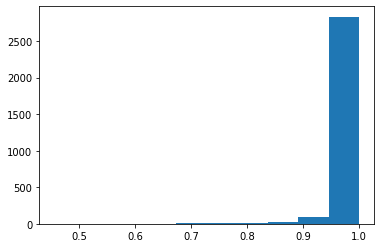

In [50]:
plt.hist(y_pred[:, -10])

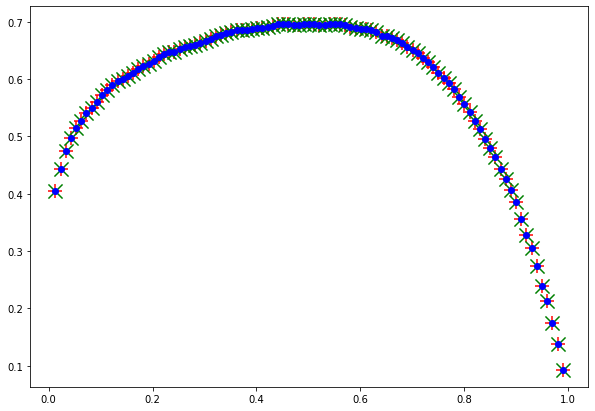

In [23]:
plt.figure(figsize=(10,7))
plt.scatter(mass_bins, corrs_am['linear_cvir'], marker='+', c='r', alpha=1, s=200)
plt.scatter(mass_bins, corrs_am['normalized_cvir'], marker='x', c='g', alpha=1, s=200)
plt.scatter(mass_bins, corrs_am['multicam_cvir'], c='b',alpha=1)

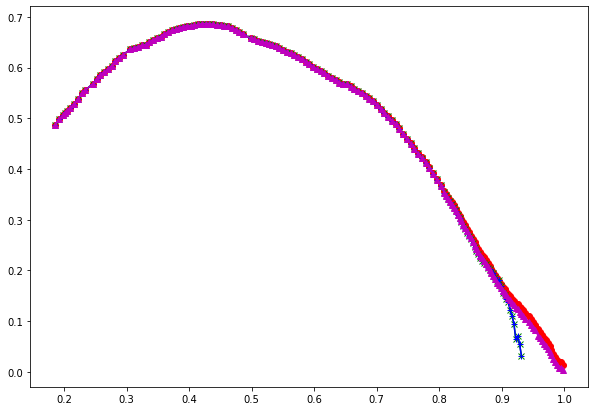

In [49]:
plt.figure(figsize=(10,7))
plt.plot(scales, corrs_ma['linear_cvir'], 'r-o')
plt.plot(scales, corrs_ma['normalized_cvir'], 'g-x' )
plt.plot(scales, corrs_ma['multicam_cvir'], 'b-+')
plt.plot(scales, corrs_ma['not_norm_multicam_cvir'], 'm-^')

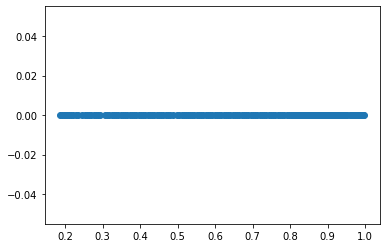

In [90]:
plt.scatter(scales, np.sum( y_pred[:, n_mbins:] == 1.0, axis=0) / len(y_pred[:, n_mbins:]))

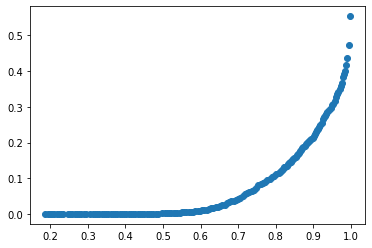

In [82]:
plt.scatter(scales, np.sum( y_test[:, n_mbins:] == 1.0, axis=0) / len(y_pred[:, n_mbins:]))

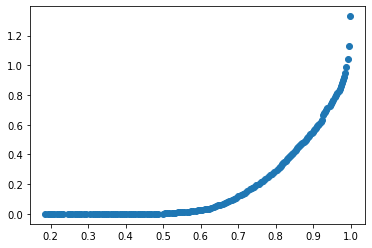

In [83]:
plt.scatter(scales, np.sum( datasets['cvir_only']['train'][1][:, n_mbins:] == 1.0, axis=0) / len(y_pred[:, n_mbins:]))

# Check where we fail

(array([3.132e+03, 6.351e+03, 4.570e+02, 3.500e+01, 1.500e+01, 8.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.01379073,  7.65827271, 14.30275469, 20.94723667, 27.59171865,
        34.23620063, 40.88068261, 47.52516459, 54.16964657, 60.81412855,
        67.45861053]),
 <BarContainer object of 10 artists>)

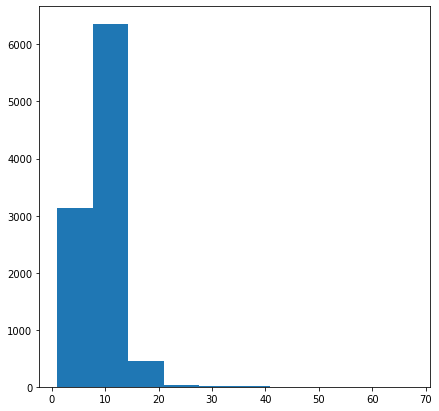

In [129]:
plt.figure(figsize=(7,7))
plt.hist(cat['cvir'])

## only normalization

In [138]:
idx = np.where(scales > 0.95)[0][0]

y = ma[:, idx].reshape(-1, 1)
x = cat['cvir'].reshape(-1, 1)

from sklearn.preprocessing import QuantileTransformer

qt_y = QuantileTransformer(n_quantiles=len(y), output_distribution="normal")
qt_y = qt_y.fit(y)

qt_x = QuantileTransformer(n_quantiles=len(x), output_distribution="normal")
qt_x = qt_x.fit(x)

from sklearn import linear_model
_x, _y = qt_x.transform(x), qt_y.transform(y)
mdl = linear_model.LinearRegression().fit(_x, _y)
_y_pred = mdl.predict(_x)
y_pred = qt_y.inverse_transform(_y_pred)

(array([1.000e+00, 9.000e+00, 1.780e+02, 1.304e+03, 3.508e+03, 1.776e+03,
        0.000e+00, 0.000e+00, 0.000e+00, 3.224e+03]),
 array([-5.19933758e+00, -4.15947007e+00, -3.11960255e+00, -2.07973503e+00,
        -1.03986752e+00,  4.89217555e-11,  1.03986752e+00,  2.07973503e+00,
         3.11960255e+00,  4.15947007e+00,  5.19933758e+00]),
 <BarContainer object of 10 artists>)

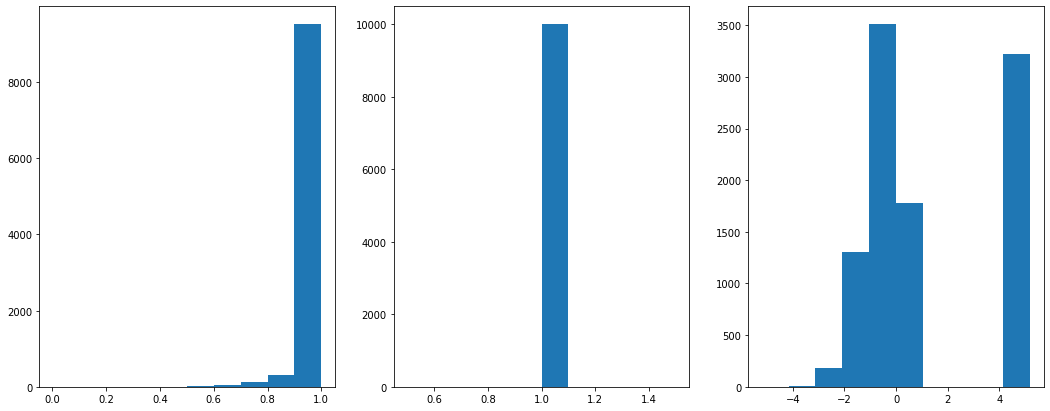

In [139]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))

ax1.hist(y)
ax2.hist(y_pred)
ax3.hist(_y)

## Just linear regression

In [136]:
idx = np.where(scales > 0.95)[0][0]
y = ma[:, idx].reshape(-1, 1)
x = cat['cvir'].reshape(-1, 1)

from sklearn import linear_model
mdl = linear_model.LinearRegression().fit(x, y)
y_pred = mdl.predict(x)


(array([3.132e+03, 6.351e+03, 4.570e+02, 3.500e+01, 1.500e+01, 8.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.94430425, 0.96863099, 0.99295772, 1.01728445, 1.04161118,
        1.06593792, 1.09026465, 1.11459138, 1.13891812, 1.16324485,
        1.18757158]),
 <BarContainer object of 10 artists>)

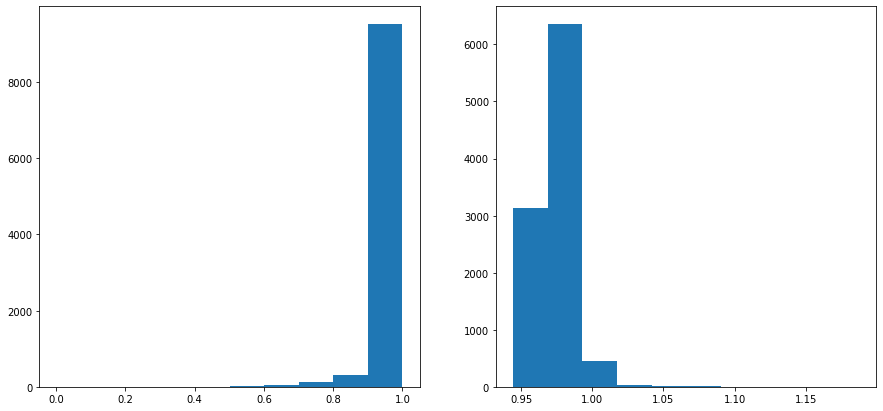

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.hist(y)
ax2.hist(y_pred)

## multicam

In [134]:
idx = np.where(scales > 0.95)[0][0]

y = ma[:, idx].reshape(-1, 1)
x = cat['cvir'].reshape(-1, 1)

from sklearn.preprocessing import QuantileTransformer

qt_y = QuantileTransformer(n_quantiles=len(y), output_distribution="normal")
qt_y = qt_y.fit(y)

qt_x = QuantileTransformer(n_quantiles=len(x), output_distribution="normal")
qt_x = qt_x.fit(x)


from sklearn import linear_model
_x, _y = qt_x.transform(x), qt_y.transform(y)
mdl = linear_model.LinearRegression().fit(_x, _y)
_y_pred1 = mdl.predict(_x)
y_pred1 = qt_y.inverse_transform(_y_pred1)

qt_pred = QuantileTransformer(n_quantiles=len(y_pred1), output_distribution='normal')
qt_pred = qt_pred.fit(y_pred1)
_y_pred = qt_pred.transform(y_pred1)
y_pred = qt_y.inverse_transform(_y_pred)

(array([    0.,     0.,     0.,     0.,     0., 10000.,     0.,     0.,
            0.,     0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

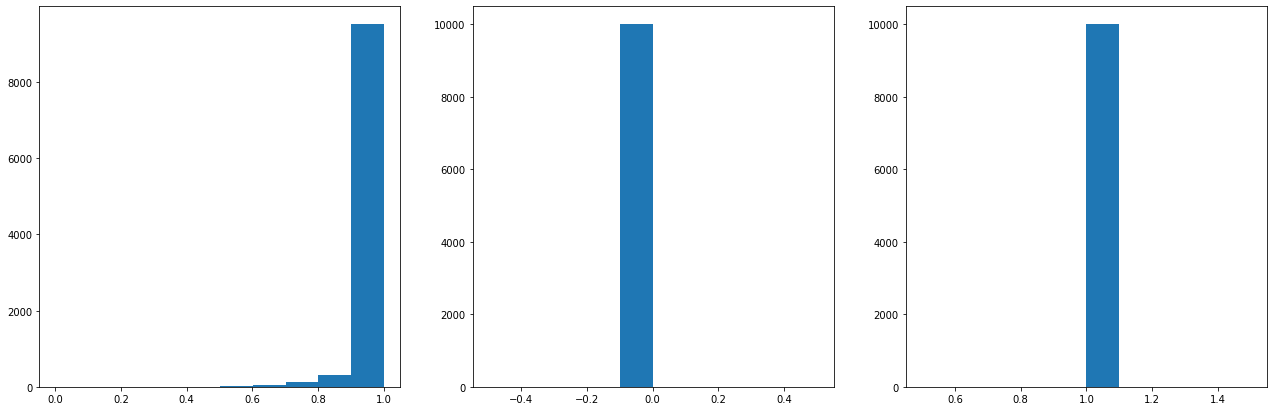

In [135]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.hist(y)
ax2.hist(y_pred)
ax3.hist(y_pred1)

## Multicam (no normalization)

In [140]:
idx = np.where(scales > 0.95)[0][0]

y = ma[:, idx].reshape(-1, 1)
x = cat['cvir'].reshape(-1, 1)

from sklearn.preprocessing import QuantileTransformer
from sklearn import linear_model

qt_y = QuantileTransformer(n_quantiles=len(y), output_distribution="normal")
qt_y = qt_y.fit(y)

mdl = linear_model.LinearRegression().fit(x, y)
y_pred1 = mdl.predict(x)

qt_pred = QuantileTransformer(n_quantiles=len(y_pred1), output_distribution='normal')
qt_pred = qt_pred.fit(y_pred1)
_y_pred = qt_pred.transform(y_pred1)
y_pred = qt_y.inverse_transform(_y_pred)

(array([3.132e+03, 6.351e+03, 4.570e+02, 3.500e+01, 1.500e+01, 8.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.94430425, 0.96863099, 0.99295772, 1.01728445, 1.04161118,
        1.06593792, 1.09026465, 1.11459138, 1.13891812, 1.16324485,
        1.18757158]),
 <BarContainer object of 10 artists>)

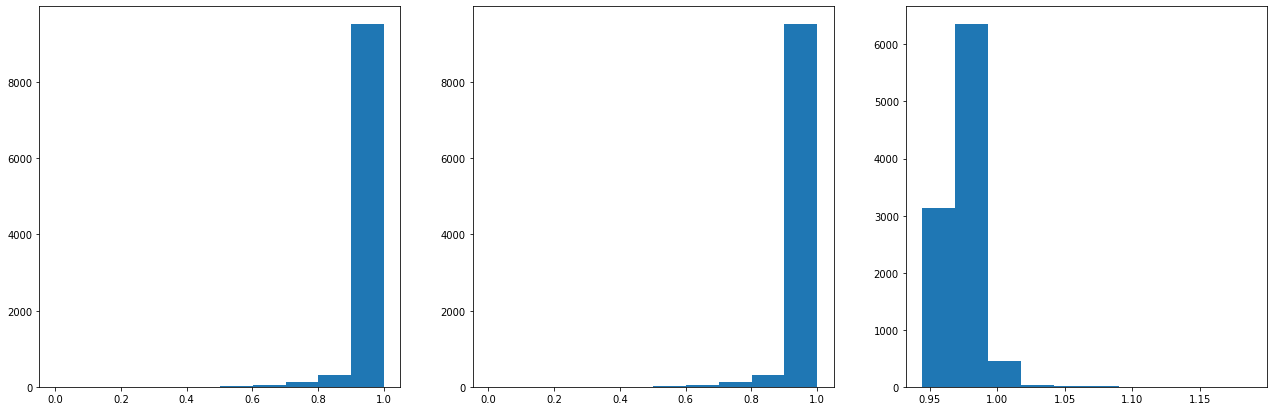

In [141]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.hist(y)
ax2.hist(y_pred)
ax3.hist(y_pred1)